## Make a precinct map for durham precinct 21

I downloaded some data from the [Durham ArcGIS server](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer).

Here is an example of the fields that each record has: [record 1](http://gisweb2.durhamnc.gov/ArcGIS/rest/services/PublicWorks/PublicWorks/MapServer/89/1)

Note: I use the form `test -f file || get file` to prevent re-running commands. You can delete the file to redownload.

In [137]:
!test -f precinct-21.shp || ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM' and PREC_ID='21'" -t_srs EPSG:4326 precinct-21.shp Precincts.shp

In [147]:
!ogr2ogr -f geojson precinct-21.geojson precinct-21.shp

In [138]:
!ogrinfo -so -al precinct-21.shp

INFO: Open of `precinct-21.shp'
      using driver `ESRI Shapefile' successful.

Layer name: precinct-21
Geometry: Polygon
Feature Count: 1
Extent: (-78.905636, 36.014804) - (-78.889773, 36.037240)
Layer SRS WKT:
GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137,298.257223563]],
    PRIMEM["Greenwich",0],
    UNIT["Degree",0.017453292519943295]]
PREC_ID: String (100.0)
ENR_DESC: String (150.0)
COUNTY_NAM: String (100.0)
OF_PREC_ID: String (50.0)
COUNTY_ID: Integer (5.0)


In [1]:
!test -f landuse.json || curl "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry=%7B%22ymax%22:832470.521274,%22xmax%22:2032594.388967,%22ymin%22:824305.219035,%22xmin%22:2027901.245138%7D&returnGeometry=false&outFields=SITE_ADDRE,OWNER_NAME,LANDUSE_DESC,LAND_USE" > landuse.json

In [2]:
!jq '.features|.[]|.attributes.LANDUSE_DESC' landuse.json | sort | uniq -c | sort -n | tail -20

   3 "CMNTY SVC/ SCHOOL        "
   3 "COM/ APARTMENT-GARDEN    "
   3 "COM/ CONV STORE W/ GAS   "
   3 "COM/ OFFICE BLDG         "
   3 "COM/ PARKING LOTS-SURFACE"
   3 "COM/ WHSE-STORAGE        "
   3 "VAC RES/ LOT-SML TR/SIDE "
   4 "COM/ 1-STY SM SGL USER   "
   4 "COM/ AUTO BODY-TIRE      "
   4 "COM/ FAST FOOD           "
   5 "COM/ MULTI-USE CAPABLE   "
   7 "COM/ CONVERTED RESIDENCE "
   7 "VAC RES/ LOT-SML TR/REAR "
   8 "COM/ 1-STY SM MULTI USER "
  15 "WILD/ PARKS & REC - CITY "
  19 "VACANT COMMERCIAL        "
  27 "VACANT COMMUNITY SERVICE "
  30 "VAC RES/ LOT-SML TRACT   "
  42 "RES/ 2-FAMILY            "
 769 "RES/ 1-FAMILY            "


Looks like the only lots that we should be interested in are the residential ones:

In [3]:
!jq '.features|.[]|.attributes.LANDUSE_DESC' landuse.json | grep '"RES' | sort | uniq -c | sort -n

   1 "RES/ RESIDENTIAL (UNDIFF)"
   1 "RES/ TOWNHOUSE W/ LAND   "
   2 "RES/ MULTIPLE DWG'S      "
  42 "RES/ 2-FAMILY            "
 769 "RES/ 1-FAMILY            "


I used paw to mess with the params, but generally I just added the `"RES` filter above to my curl request. Note that ArcGIS does not create geojson out of the box. I used the ogr2ogr tool to convert it ([thanks SO](http://gis.stackexchange.com/questions/13029/converting-arcgis-server-json-to-geojson)).

But what I really want is everything within the precinct 21 area, so I need to make an intersection.

I needed to get the ids of all the lots, then download them in chunks, otherwise it fails with an exceededTransferLimit warning

In [244]:
import json
import os
import requests

all_lots_url = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry=%7B%22ymax%22:832470.521274,%22xmax%22:2032594.388967,%22ymin%22:824305.219035,%22xmin%22:2027901.245138%7D&returnGeometry=true&outSR=4326&outFields=*"
# residential addresses - but some 'non residentials' still have voters:
# res_lots_url = "{}&where=LANDUSE_DESC%20like%20%27RES%25%27".format(all_lots_url)
res_lots_url = "{}&where=LANDUSE_DESC%20like%20%27%25RES%25%27".format(all_lots_url)

# non Durham properties:
# res_lots_url = "{}&where=lower(OWNER_NAME)%20not%20like%20%27%25durham%25%27".format(all_lots_url)

def strip_features(data):
    for row in data['features']:
        for k,v in row['attributes'].items():
            if isinstance(v, str):
                row['attributes'][k] = v.strip()
    return data

def download_arcgis(url, filename):   
    ids_request = requests.get("{}&returnIdsOnly=true".format(url))
    ids = ids_request.json()
    id_chunks = [ids['objectIds'][x:x+150] for x in range(0, len(ids['objectIds']), 150)]

    first_data = None
    for chunk in id_chunks:
        chunk_url = "{}&objectIds={}".format(url, ','.join(str(c) for c in chunk))
        data_request = requests.get(chunk_url)
        data = data_request.json()
        if first_data is None:
            first_data = strip_features(data)
        else:
            first_data['features'].extend(strip_features(data)['features'])

    jsonfile = '{}.json'.format(filename)
    with open(jsonfile,'w') as outfile:
        json.dump(first_data, outfile)        
        
if not os.path.exists('lots.json'):
    download_arcgis(res_lots_url, 'lots')
    !rm -f lots.geojson && ogr2ogr -f GeoJSON lots.geojson lots.json OGRGeoJSON
    !rm -f lots.shp && ogr2ogr lots.shp lots.geojson

if not os.path.exists('all_lots.json'):
    download_arcgis(all_lots_url, 'all_lots')
    !rm -f all_lots.geojson && ogr2ogr -f GeoJSON all_lots.geojson all_lots.json OGRGeoJSON
    !rm -f all_lots.shp && ogr2ogr all_lots.shp all_lots.geojson

Warning 6: Normalized/laundered field name: 'SplitTaxDis' to 'SplitTaxDi'
Warning 6: Normalized/laundered field name: 'SplitTaxDec' to 'SplitTaxDe'
Warning 6: Normalized/laundered field name: 'EXEMPT_CODE' to 'EXEMPT_COD'
Warning 6: Normalized/laundered field name: 'LANDUSE_DESC' to 'LANDUSE_DE'
Warning 6: Normalized/laundered field name: 'SplitTaxDis' to 'SplitTaxDi'
Warning 6: Normalized/laundered field name: 'SplitTaxDec' to 'SplitTaxDe'
Warning 6: Normalized/laundered field name: 'EXEMPT_CODE' to 'EXEMPT_COD'
Warning 6: Normalized/laundered field name: 'LANDUSE_DESC' to 'LANDUSE_DE'


In [245]:
import geopandas as gpd
lots = gpd.GeoDataFrame.from_file("lots.shp")
precinct = gpd.GeoDataFrame.from_file("precinct-21.shp")

print(len(lots))

lots = lots.to_crs({'init': 'epsg:4326'})
precinct = precinct.to_crs({'init': 'epsg:4326'})

lots_in_precinct = gpd.sjoin(lots, precinct, op='within')

print(len(lots_in_precinct))

lots_in_precinct.to_file('precinct-21-lots.shp')

1272
1072

In [246]:
!rm -f precinct-21-lots.geojson && ogr2ogr -f geojson precinct-21-lots.geojson precinct-21-lots.shp

## Residential Addresses in Princinct 21

In [247]:
import folium

map = folium.Map(location=[36.025, -78.899], tiles='CartoDB positron', zoom_start=15)
map.choropleth(geo_path='precinct-21-lots.geojson')
map.choropleth(geo_path='precinct-21.geojson', fill_opacity=0.2, line_opacity=0)
map

In [68]:
import pandas as pd

voters = pds.read_csv('ncvoter32.txt', sep=None)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


LANDUSE_DE                                 OWNER_NAME  \
597  RES/ 1-FAMILY  BENNETT THOMAS LEE III BENNETT JENNIFER R   
564  RES/ 1-FAMILY                      MORGAN DANIEL WILLIAM   
971  RES/ 1-FAMILY                            OSBORNE DIANA N   
770  RES/ 1-FAMILY                            SANDLER AARON J   
563  RES/ 1-FAMILY                 BOOKER VALERIE BOOKER ALAN   

              SITE_ADDRE                                           geometry  \
597     3023 FARTHING ST  POLYGON ((-78.89340634768027 36.02950696653577...   
564  111 W DELAFIELD AVE  POLYGON ((-78.89280068310266 36.02958242021131...   
971  3011 SHENANDOAH AVE  POLYGON ((-78.89491395238912 36.02959678216623...   
770  109 W DELAFIELD AVE  POLYGON ((-78.89290782423404 36.03009003181342...   
563  107 W DELAFIELD AVE  POLYGON ((-78.89235083790959 36.02964605856238...   

     index_right  COUNTY_ID COUNTY_NAM                  ENR_DESC OF_PREC_ID  \
597            0         32     DURHAM  21_CLUB BOULEVARD SCHOOL       None   
564            0         32     DURHAM  21_CLUB BOULEVARD SCHOOL       None   
971            0         32     DURHAM  21_CLUB BOULEVARD SCHOOL       None   
770            0         32     DURHAM  21_CLUB BOULEVARD SCHOOL       None   
563            0         32     DURHAM  21_CLUB BOULEVARD SCHOOL       None   

    PREC_ID  
597      21  
564      21  
971      21  
770      21  
563      21

In [248]:
voters_in_precinct21 = voters[voters.precinct_desc == '21']

map = folium.Map(location=[36.025, -78.899], tiles='CartoDB positron', zoom_start=15)
map.choropleth(geo_path='precinct-21-lots.geojson',
               columns=['mail_addr1', 'birth_age'],
               data=voters_in_precinct21,
               key_on='properties.SITE_ADDRE',
               fill_color='YlGn', line_opacity=0,
              )
map

In [272]:
# voters_in_precinct21.dtypes
# pd.value_counts()
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

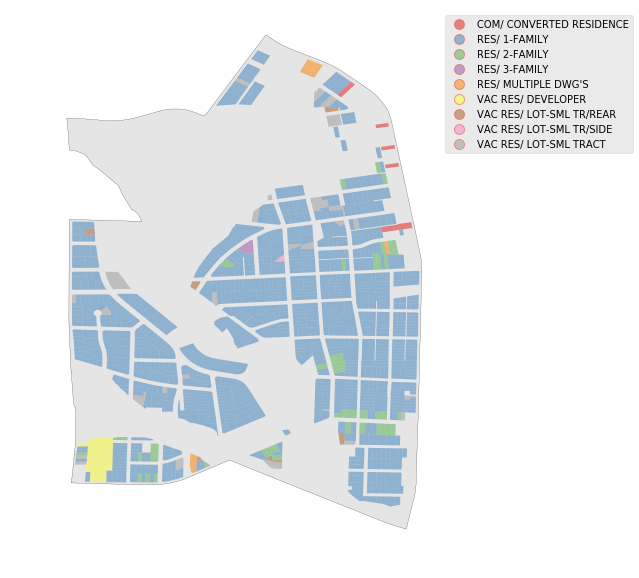

In [287]:
import geopandas as gpd

all_lots_pd = gpd.read_file('precinct-21-lots.shp')
precinct_boundary_pd = gpd.read_file('precinct-21.shp')

fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
all_lots_pd.plot(ax=ax, column='LANDUSE_DE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))

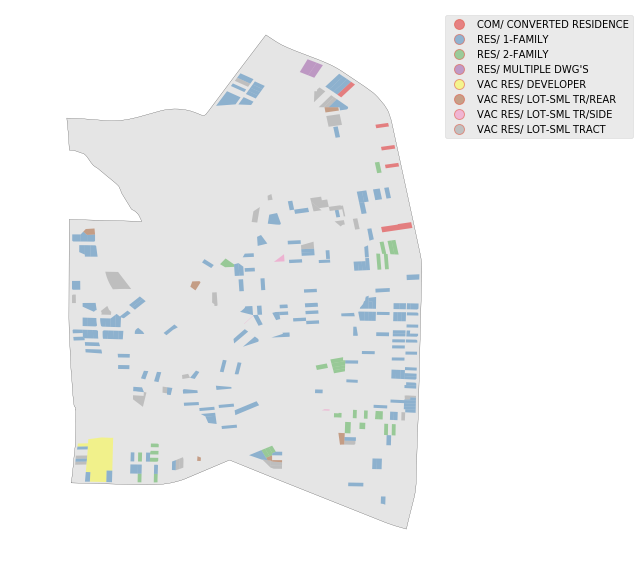

In [289]:
# so now that I have a shapefile of residential addresses, lets make files of non-voters.

lot_attribs = [d['attributes'] for d in first_data['features']]
lot_attribs_df = pd.DataFrame(lot_attribs)

# lot_attribs_df['SITE_ADDRE'] = lot_attribs_df['SITE_ADDRE'].apply(str.strip)
non_voters_pd = all_lots_pd.query('SITE_ADDRE not in @voters_in_precinct21.mail_addr1')

fig, ax = plt.subplots(1, figsize=(7,10))
precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
non_voters_pd.plot(ax=ax, column='LANDUSE_DE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.0, 0.0))